<a href="https://colab.research.google.com/github/laura-turnbull-lloyd/STDH22_23/blob/main/Lecture5_spatial_autocorrelation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction


In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [140]:
#@title Install modules
!pip install pandas fiona shapely pyproj rtree 

import pandas as pd
# to make sure that pandas outputs values in an easy to read format, we can customise the output format:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import colors
!pip install geopandas
import geopandas as gpd
import shapely
import pyproj
import rtree

import seaborn

!pip install wget
!pip install pysal
import pysal
import wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Opening the data we're going to be working with this week
The data we're working with this week is from the National Interagency Fire Center: https://data-nifc.opendata.arcgis.com/

In [ ]:
#Open the image from the web
url="https://opendata.arcgis.com/api/v3/datasets/585b8ff97f5c45fe924d3a1221b446c6_0/downloads/data?format=geojson&spatialRefId=4326&where=1%3D1&geometry=%7B%22spatialReference%22%3A%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D%2C%22xmin%22%3A-13850879.295110002%2C%22ymin%22%3A3861287.808129515%2C%22xmax%22%3A-12700287.432793807%2C%22ymax%22%3A5203646.083343174%2C%22type%22%3A%22extent%22%7D"
#the link below is for a smaller area (useful for proof of concept if the above data takes too long to run)
#url = "https://opendata.arcgis.com/api/v3/datasets/585b8ff97f5c45fe924d3a1221b446c6_0/downloads/data?format=geojson&spatialRefId=4326&where=1%3D1&geometry=%7B%22spatialReference%22%3A%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D%2C%22xmin%22%3A-13776521.301103547%2C%22ymin%22%3A4777065.293519012%2C%22xmax%22%3A-13312762.622808278%2C%22ymax%22%3A5166466.120273124%2C%22type%22%3A%22extent%22%7D"
fire = wget.download(url)

Upload the wildfire data to google colab - this might take a few minutes as it's a large file.
These data have been downloaded from: https://data-nifc.opendata.arcgis.com/


In [116]:
fires = gpd.read_file(fire)
# don't worry about the warning message you'll get here...


Streaming output truncated to the last 5000 lines.


View the coordinate system:

In [ ]:
fires.crs

You can see that the data are in a geogrpahic coordinate system. Let's project the data to make it easier to work with (especially for area calculations!).

In [ ]:
#Convert (reproject) those geometries into Lambert Azimuthal Equal Area projection (EPSG: 3035). Changing the CRS is really easy to do in Geopandas with .to_crs() -function. As an input for the function, you should define the epgs value of the target CRS that you want to use.

# Let's take a copy of our layer
fires_proj = fires.copy()

# Reproject the geometries by replacing the values with projected ones
fires_proj = fires_proj.to_crs(epsg=5070)


In [ ]:
fires_proj # to view the data

,OBJECTID,poly_IncidentName,poly_FeatureCategory,poly_MapMethod,poly_GISAcres,poly_CreateDate,poly_DateCurrent,poly_PolygonDateTime,poly_Acres_AutoCalc,poly_GlobalID,...,irwin_ArchivedOn,irwin_ModifiedOnDateTime_dt,irwin_CreatedOnDateTime_dt,GlobalID,irwin_IsCpxChild,irwin_CpxName,irwin_CpxID,SHAPE_Length,SHAPE_Area,geometry
0,127,Coleman,Wildfire Daily Fire Perimeter,Mixed Methods,562.91350,2021-05-04T22:50:38+00:00,2021-05-04T22:50:38+00:00,None,562.91177,{951569B8-EA6B-443B-8BF7-022AE1DFC937},...,None,2021-03-26T19:01:00+00:00,2020-10-18T20:02:59+00:00,{1E48F205-2208-4DBD-8A48-B739FDEACF9C},NaN,None,None,0.12004,-0.00023,"MULTIPOLYGON (((-2233112.268 1750487.910, -223..."
1,128,Patrick,Wildfire Daily Fire Perimeter,Mixed Methods,0.15168,2021-05-04T22:51:03+00:00,2021-05-04T22:51:03+00:00,None,0.15168,{08D5DE2B-51A0-420A-812F-35902565E93A},...,None,2020-06-19T20:31:59+00:00,2020-05-01T22:15:24+00:00,{447213E7-190B-4E48-B60C-D0E492EFD576},NaN,None,None,0.00112,-0.00000,"MULTIPOLYGON (((-1987446.492 2084089.348, -198..."
2,130,Sloan 2,Wildfire Daily Fire Perimeter,Mixed Methods,44.30052,2021-05-04T22:50:52+00:00,2021-05-04T22:50:52+00:00,None,44.30035,{7AE9D007-FBA4-440B-972B-69791E156BE8},...,None,2021-01-27T20:56:40+00:00,2020-05-08T02:54:29+00:00,{C882C4C8-1420-4D68-9012-B24EDA77D6B7},NaN,None,None,0.03239,-0.00002,"MULTIPOLYGON (((-1707133.000 1597540.598, -170..."
3,136,Beach,Wildfire Daily Fire Perimeter,Mixed Methods,0.93000,2021-05-04T22:55:36+00:00,2021-05-04T22:55:36+00:00,None,0.93447,{ACB5D2C6-9B76-4E5D-994F-F0C852A728C5},...,None,2021-03-27T17:17:47+00:00,2021-03-07T15:01:34+00:00,{BA4D59C9-E0D0-4B4C-9D7F-C6CFC3E415EB},NaN,None,None,0.00417,-0.00000,"MULTIPOLYGON (((-1664353.510 1427329.073, -166..."
4,150,Elkhorn,Wildfire Final Fire Perimeter,Mixed Methods,51576.74401,2022-10-31T20:49:11+00:00,2022-10-31T20:49:11+00:00,2022-10-31T20:49:10+00:00,51617.21992,{C4EF589B-472A-4E98-B881-FD31272B2412},...,None,2021-04-16T21:51:29+00:00,2020-09-06T23:44:46+00:00,{E2412576-897C-4DC6-8ABE-69F1BB353FA1},1.00000,AUGUST COMPLEX,{EE343B88-0ADB-4C25-B744-6B4CE9DCC6DA},1.64370,-0.02207,"MULTIPOLYGON (((-2238959.370 2212456.417, -223..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1809,20350,Spanish,Wildfire Final Fire Perimeter,Auto-generated,0.10000,2022-11-03T15:31:29+00:00,2022-11-03T15:31:29+00:00,2022-11-03T15:31:29+00:00,0.32664,{9B2DAFDA-B40A-4662-95BD-C07579A6FA7D},...,None,2022-11-02T15:06:28+00:00,2022-10-23T22:19:27+00:00,{CC666FC2-EA4A-4595-927C-5CE65A054B1F},0.00000,None,None,0.00163,-0.00000,"MULTIPOLYGON (((-2086484.365 2160090.018, -208..."
1810,20373,LOST,Wildfire Daily Fire Perimeter,Hand Sketch,0.10000,2022-06-17T22:09:02+00:00,2022-10-30T15:55:46+00:00,2022-06-18T02:48:03+00:00,0.11682,{2FBDBEE3-ECF5-405E-80F0-C63FEE492BA9},...,None,2022-06-21T20:53:47+00:00,2022-06-17T22:08:51+00:00,{F1AD76EF-267A-4278-99CC-13F52852536A},0.00000,None,None,0.00090,-0.00000,"MULTIPOLYGON (((-2083446.167 2060582.384, -208..."
1811,20375,FOX,Wildfire Daily Fire Perimeter,Auto-generated,0.10000,2022-10-30T19:40:35+00:00,2022-10-30T19:40:35+00:00,2022-10-30T01:05:59+00:00,3.93513,{DE57F2DC-3620-4DD6-B7E7-8661E69B3AB3},...,None,2022-11-01T17:51:41+00:00,2022-10-29T20:09:51+00:00,{B0BC844B-9FA3-4CE8-989F-D2122B188EB3},0.00000,None,None,0.00717,-0.00000,"MULTIPOLYGON (((-2125002.437 2329960.861, -212..."
1812,20400,Butterfly,Wildfire Final Fire Perimeter,Auto-generated,0.10000,2022-11-03T15:31:01+00:00,2022-11-03T15:31:01+00:00,2022-11-03T15:31:01+00:00,0.10698,{FDA90B82-7639-4CC0-A707-C479AE370D65},...,None,2022-11-02T17:33:31+00:00,2022-10-30T14:21:19+00:00,{FA60CC07-4F6D-47EB-8092-367684AD7100},0.00000,None,None,0.00119,-0.00000,"MULTIPOLYGON (((-2088701.877 2163894.781, -208..."


Let's view the data

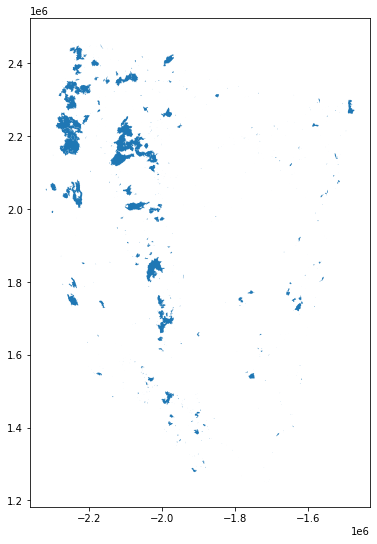

In [ ]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(12, 9))
fires_proj.plot(ax=ax)
plt.show()

Most spatial pattern analyses are focussed on the analysis of point patterns that don't consider attribute information (i.e. they only focus in the coordinates of a point). Therefore, in order to undertake this type of analysis, we can convert the wildfire data to points, based on the centroid (i.e. the central point) of each wildifre polygon. 

Of course, there are limitations in representing areal data as points, as you started to explore last week with the landslide data.

In [ ]:
#points['geometry'] = points['geometry'].centroid
fire_pt = fires_proj.copy()
# change geometry 
fire_pt['geometry'] = fire_pt['geometry'].centroid


#Exercise 1:Quantitatively testing if points exhibit spatial patterning

##Showing Patterns as Dots on a Map
The first step to get a sense of what the spatial dimension of this dataset looks like is to plot it. At its most basic level, we can generate a scatter plot with seaborn:

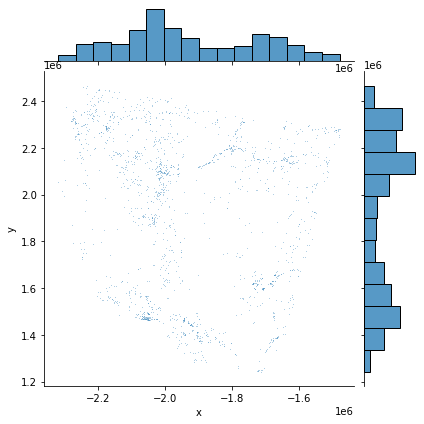

In [ ]:
fire_pt["x"] = fire_pt.geometry.x
fire_pt["y"] = fire_pt.geometry.y

seaborn.jointplot(x="x", y="y", data=fire_pt, s=0.5);

Whilst it looks like there are some spatial patterns in the data, it's useful to be able to say quantitatively if there is a pattern (therefore building upon the simple density approachs of pattern visualisation you explored last week), by testing an observed pattern against complete spatial randomness (CSR), in which the location and number of points is totally random; there is neither clustering nor dispersion.

We can do this by using the <pointpats> package to simulate CSR from a given point set, using the <pointpats.random> module.

In [ ]:
#load the module
from pointpats import (
    distance_statistics,
    QStatistic,
    random,
    PointPattern,
)

In [ ]:
#create CSR from the point set
coordinates = fire_pt[["x", "y"]].values
random_pattern = random.poisson(coordinates, size=len(coordinates))

It's useful to first visually compare random pattern with the observed pattern.

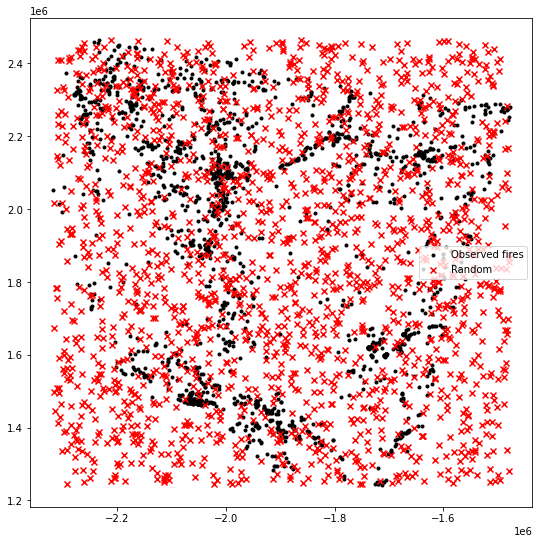

In [ ]:
f, ax = plt.subplots(1, figsize=(9, 9))
plt.scatter(
    *coordinates.T,
    color="k",
    marker=".",
    label="Observed fires"
)
plt.scatter(*random_pattern.T, color="r", marker="x", label="Random")
ax.legend(ncol=1, loc="right")
plt.show()

## Quadrat statistics
Quadrat statistics examine the spatial distribution of points in an area in terms of the count of observations that fall within a given cell. By examining whether observations are spread evenly over cells, the quadrat approach aims to estimate whether points are spread out, or if they are clustered into a few cells. Strictly speaking, quadrat statistics examine the evenness of the distribution over cells using a chi-squared statistical test.

In the pointpats package, you can visualize the results using the following QStatistic.plot() method. This shows the grid used to count the events, as well as the underlying pattern.

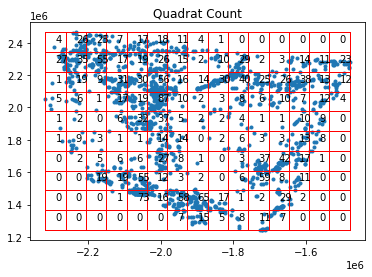

In [ ]:
qstat = QStatistic(coordinates, nx=15, ny=10) # nx and ny are the number of cells in the x and y directions
qstat.plot()

In this case, for a fifteen by ten grid spanning the point pattern, we can see a mix of very high values and very low values. This means that the chi-squared test (which compares how likely this distribution is if the cell counts are uniform) will be statistically significant, with a very small p-value:

In [ ]:
qstat.chi2_pvalue

0.0

In [ ]:
qstat.chi2

3223.982359426681

Now, let's repeat the analysis for the CSR dataset that we generated:

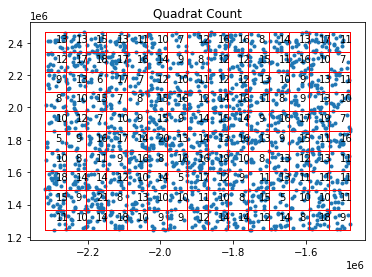

In [ ]:
qstat_null = QStatistic(random_pattern, nx=15, ny=10)
qstat_null.plot()

In [ ]:
qstat_null.chi2

136.66152149944872

In [ ]:
qstat_null.chi2_pvalue

0.7569687239311023

**What does this analysis show?**
**What are potential issues with the above analysis?**

We learned last week that quadrat analysis can be sensitive to the placing of a grid over a study area, and to the size of the grid. 

**Modify the code above to determine if the significance values of spatial clustering varies with quadrat size**


# Exercise 2: Spatial autocorrelation
Our brains are very powerful pattern recognition machines. However, sometimes they can be too powerful and lead us to detect false positives, or patterns where there are no statistical patterns. This is a particular concern when dealing with visualization of irregular polygons of differing sizes and shapes.

The notion of spatial autocorrelation relates to the existence of a "functional relationship between what happens at one point in space and what happens elsewhere" (Anselin, 1988). Spatial autocorrelation thus has to do with the degree to which the similarity in values between observations in a dataset is related to the similarity in locations of such observations. This is similar to the traditional idea of correlation between two variables, which informs us about how the values in one variable change as a function of those in the other, albeit with some key differences discussed in this chapter. In a similar fashion, spatial autocorrelation is also related (but distinct) to temporal counterpart, temporal autocorrelation, which relates the value of a variable at a given point in time with those in previous periods. In contrast to these other ideas of correlation, spatial autocorrelation relates the value of the variable of interest in a given location, with values of the same variable in other locations. 

Two examples of global spatial autocorrelation measures are Ripley's K and Moran's I. Moran's I deals with spatial and attribute similarity.

In the case of wildfires, in a hazard and risk context, we're interested in where they occur in space and how large they are (this is the main attribute we're often interested in -- an alternative attribute of interest might include burn severity, for example).

To get the wildfire data into a suitable format for global autocorrelation analysis that takes into account location and attribute, we will process the data as we did for the landslide data last week, to derive a map of wildfire area density, over which we can apply global spatial autocorrelation analysis. 

The next few blocks of code repeat the analysis you did last week, but this time applied to the wildfire dataset.

In [ ]:
from shapely.geometry import Polygon

# total area for the grid
xmin, ymin, xmax, ymax= fires_proj.total_bounds # this function extracts the bounding coordinates of the landslide data
width = 10000
height =10000
# projection of the grid - this sets the crs to be the same as the data we area already working with
crs = fires.crs
rows = int(np.ceil((ymax-ymin) /  height))
cols = int(np.ceil((xmax-xmin) / width))
XleftOrigin = xmin
XrightOrigin = xmin + width
YtopOrigin = ymax
YbottomOrigin = ymax- height
polygons = []
for i in range(cols):
   Ytop = YtopOrigin
   Ybottom =YbottomOrigin
   for j in range(rows):
       polygons.append(Polygon([(XleftOrigin, Ytop), (XrightOrigin, Ytop), (XrightOrigin, Ybottom), (XleftOrigin, Ybottom)])) 
       Ytop = Ytop - height
       Ybottom = Ybottom - height
   XleftOrigin = XleftOrigin + width
   XrightOrigin = XrightOrigin + width

grid = gpd.GeoDataFrame({'geometry':polygons}, crs=crs)


In [ ]:
fires_intersect = fires_proj.overlay(grid, how='intersection', keep_geom_type=False)
fires_intersect['fire_area'] =fires_intersect.apply(lambda row: row.geometry.area,axis=1) # calculate the area of each landslide segment
fires_intersect['fire_index'] = fires_intersect.index

In [ ]:
merged = gpd.sjoin(grid, fires_intersect, predicate = 'contains', how='left')
merged['grid_index'] = merged.index
dissolve_merged = merged.dissolve(by='grid_index', aggfunc='sum') # sums up all the values in the area column
dissolve_merged['cellarea'] =dissolve_merged.apply(lambda row: row.geometry.area,axis=1)

In [ ]:
dissolve_merged['area_density'] = (dissolve_merged['fire_area']/dissolve_merged['cellarea'])*100

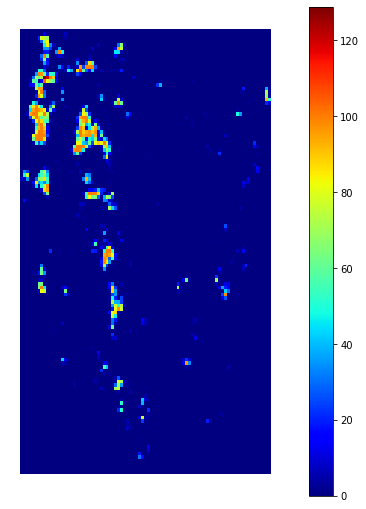

In [ ]:
#dissolve_merged.plot(column="area_density", aspect = 1)
f, ax = plt.subplots(1, figsize=(9, 9))
dissolve_merged.plot(ax=ax, column='area_density', cmap='jet', legend = True) # here, cmap = 'jet' specifies the colour ramp I've chosen to use.
plt.autoscale(True)
ax.set_axis_off()

You'll notice that the maximum area density value is > 100. We can check the exact value using:

In [ ]:
dissolve_merged.area_density.max()

128.83483104561338

This area density value > 100 indicates that there are overlapping polygons, which in the context of this analysis is fine, as it still gives us an overall indication of the area attribute for each grid cell.

The final piece of information we need before we can delve into autocorrelation is the spatial weights matrix. We will use eight nearest neighbors for the sake of the example, but other optons are also available.

In [ ]:
from pysal.lib import weights

# Generate W from the GeoDataFrame
w = weights.KNN.from_dataframe(dissolve_merged, k=8)
# Row-standardization
w.transform = "R"

##Spatial lag calculation
Autocorrelation is correlation of a variable with its lagged self. In the sense used here, lag can be thought of as an offset, and when spatial autocorrelation is considered a lag is a distance across space.

It therefore follows that the spatial lag is a key element of many spatial analysis techniques, and underpins autocorrelation analysis. Its calculation is fully supported in Pysal. To compute the spatial lag of wildfire area density:

In [ ]:
dissolve_merged["area_density_lag"] = weights.spatial_lag.lag_spatial(
    w, dissolve_merged["area_density"]
)

## Moran's I Overview <a name="moran"></a>

One of the most widely used measures of spatial autocorrelation is Moran’s I, which is a translation of non-spatial correlation (for two continuous variables at the same locations) into a spatial context (for one continuous variable at different locations).

Essentially, Moran’s $I$ is the correlation coefficient for the relationship between the values of a variable and the spatially lagged local mean values. The concept of a spatially lagged local mean is covered in another notebook.   

But we can break this down to understand a little better what's going on (see as O'Sullivan and Unwin (2010, p205)). 

The equation for Moran's $I$ might seem quite intimidating:

$$
I = \dfrac{n}{\sum_i\sum_j w_{ij}} \dfrac{\sum_i\sum_j w_{ij} \, z_i \, z_j}{\sum_i z_i^2}
$$

We can break this down to understand a little better what's going on. Remember that in mathematical notation the $\sum$ (greek upper-case sigma) means 'sum' and that placing two items next to one another means they should be multiplied together. So the first main thing to notice about the equation for Moran's $I$ is that it is two fractions multiplied together. 

Next, we can define what all the letters mean:
- $n$ is the number of observations (i.e. locations) in our data set
- $z_i$ is the standardized value of our variable at location *i*
- $z_j$ is the standardized value of our variable at location *j*
- $w_{ij}$ is the value in the weights matrix for the relationship between locations *i* and *j* (i.e. the number in the *i*-th row and the *j*-th column)

Remember that the standardised value *z* of a variable *y* is given by:

$$
\frac{(y-\bar{y})}{\sigma_y}
$$

where $\bar{y}$ is *the mean of $y$* and $\sigma_y$ is *the standard deviation of $y$*. 

The numerator on top of the second fraction is the important bit as this is what is essentially calculating the autocorrelation. Everything else is normalizing $I$ so that its value falls between -1 and +1. Similar to Pearson's $r$ for non-spatial correlation, a value near +1 means strong positive autocorrelation and a value near -1 means strong negative correlation. However, as O'Sullivan and Unwin (2010) note,

> The value [of $I$] is not strictly in the range -1 to + 1, as it is impossible for a map to be perfectly autocorrelated, whether positively or negatively, except in very unusual situations. Generally speaking, an index score of 0.3 or more, or of -0.3 or less, is an indication of relatively strong autocorrelation.


##Calculating Global Moran's I

In order to calculate Moran's I in our dataset, we can call a specific function in ```esda```  directly (before that, let us row standardized the w object again):

In [ ]:
from pysal.explore import esda
w.transform = "R"
moran = esda.moran.Moran(dissolve_merged["area_density"], w)

The method `Moran` creates an object that contains much more information than the actual statistic. If we want to retrieve the value of the statistic, we can do it this way:

In [117]:
round(moran.I,3)

0.643

Moran's I values can range between -1 and 1 and are interpreted as follows:

> -1 is perfect clustering of dissimilar values (you can also think of this as perfect dispersion)

> 0 is no autocorrelation (perfect randomness)

> +1 indicates perfect clustering of similar values (it’s the opposite of dispersion)

**Based on your analysis of the wildfire data, how would you describe autocorrelation within the dataset?**


The other bit of information we will extract from Moran's I relates to statistical inference: how likely is the pattern we observe in the map and the pattern that Moran's I captures in its value likely to be generated by an entirely random process? If we considered the same variable but shuffled its locations randomly, would we obtain a map with similar characteristics? To obtain insight into these questions, `esda` performs a simulation and returns a measure of certainty about how likely it is to obtain a pattern like the one we observe under a spatially random process. This is summarized in the p_sim attribute:

In [ ]:
moran.p_sim

0.001

So with this very small pseudo p-value we can be very confident (e.g. 99% confident) that rejecting the null hypothesis is the correct thing to do (because pseudo p < 0.01). In turn, this means we can say that at 99% confidence there is positive spatial autocorrelation (according to the Moran's  I  statistic).

To check visually, let's plot a histogram of all the simulated values of Moran's  I  compare to our value (the dashed red line):

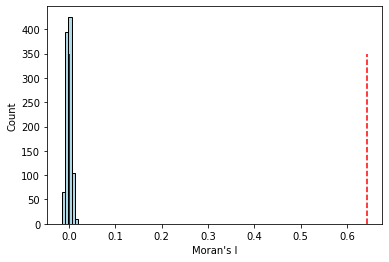

In [119]:
plt.hist(moran.sim, 5, facecolor='lightblue', edgecolor='black')
plt.vlines(moran.I, 0, 350, color='r', linestyle="--")
plt.vlines(moran.EI, 0, 350)
plt.xlabel("Moran's I")
plt.ylabel("Count")
plt.show()

The blue vertical line above is the mean value of $I$ from the permutations (from `.EI`); in this case very close to zero which indicates no spatial autocorrelation which makes sense given that the permutations are randomly generated spatial configurations of the leave vote percentage data. 

And we can see that our $I$ value of 0.64 is far greater than all value of $I$ for the permutations; this helps to confirm our intuition that our value of 0.64 is very, very unlikely to have occured by chance. 

## Local Indicators of Spatial Association <a name="lisa"></a>

The Moran's $I$ value we have seen above gives us a measure of spatial autocorrelation across the whole map for our variable of interest. It is said to be a *global* measure of spatial autocorrelation. While it can tell us in whether observations of similar values are generally clustered or dispersed, it cannot tell us *where* that clustering or dispersion is more or less pronounced across the map. 

Therefore, to investigate where clusters of large wildfires occur, or clusters of small wildfires occur, we need to consider *local* measures of spatial autocorrelation.  

These local measures consider each individual observation and have become known as [Local Indicators of Spatial Association](http://doi.org/10.1111/j.1538-4632.1995.tb00338.x), or LISAs for short. LISAs allow us to understand how indvidual locations are related to their neighbours in ways that might be different to other locations. As we will see there are four general types:

1. *hot spots* are cluster locations with high values whose neighbours also have high values
2. *cold spots* are cluster locations with low values whose neighbours also have low values
3. *doghnuts* are outlier locations with low values surrounded by neighbours with high values
4. *diamonds* (in the rough) are outlier locations with high values surrounded by neighbours with low values

Identifying such locations also demands that we consider if local measures are statistically significant. 

##Moran plot
To identify the different types of location using Moran's  I , we need to examine how locations' values relate to the mean of their neighbours' values. We can calculate the mean of neighbours' values using the lag_spatial function with a row-standardized spatial weights matrix:

In [156]:
dissolve_merged['area_density_lag'] = weights.spatial_lag.lag_spatial(w, dissolve_merged['area_density'])

The next step is to standardize our variable and its local mean version. That is, we calculate a z value for each variable (using the equation highlighted above):

In [157]:
def standardize(df, var):
    
    newname = var + '_z'
    df[newname] = (df[var] - df[var].mean()) / df[var].std()

standardize(dissolve_merged,'area_density')
standardize(dissolve_merged,'area_density_lag')

To visualise the relationship between values and the means of neighbour's values (local means), we can use a scatter plot: 

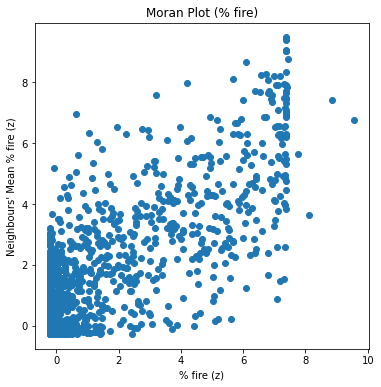

In [161]:
# Setup the figure and axis
fig, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
plt.scatter(dissolve_merged['area_density_z'], dissolve_merged['area_density_lag_z'])

# Display
ax.set_title('Moran Plot (% fire)')
ax.set_xlabel("% fire (z)")
ax.set_ylabel("Neighbours' Mean % fire (z)")
plt.show()

This plot of the value of our variable of interest (in this case wildfire burn area %) against the means of neighbours' values is known as a *Moran Plot*. Global Moran’s I is effectively the correlation coefficient for the relationship shown in this plot. 

The plot shows a positive relationship between both variables. This is indicates the presence of positive spatial autocorrelation: similar values tend to be located close to each other. Remember our global Moran's $I$ was 0.65, indicating a positive spatial autocorrelation and we can see this pattern in the Moran Plot above. This means that the overall trend is for high values to be close to other high values, and for low values to be surrounded by other low values. This, however, does not mean that this is the only case in the dataset: there can of course be particular situations where high values are surrounded by low ones, and vice versa. But it means that, if we had to summarize the main pattern of the data in terms of how clustered similar values are, the best way would be to say they are positively correlated and, hence, clustered over space. 

In the context of the example, this can be interpreted along the lines of: regions with large wildfire burn areas tend to be located near other regions that also had large burn areas, and regions with small wildfire burn areas tend to be located near other regions with small wildfire burn areas. 

**Can you think of reasons why this might be?**



While Global $I$ is useful to understand the overall spatial autocorrelation in our map, to start thinking about *local* spatial autocorrelation we need to examine individual points in the scatter plot. Remember, each point in the Moran Plot is a location.

Because we have standardized our values and local mean values, the overall means will be zero. So by adding lines running through zero on each axis we can now identify which of four types each point (i.e. location) belongs to:  

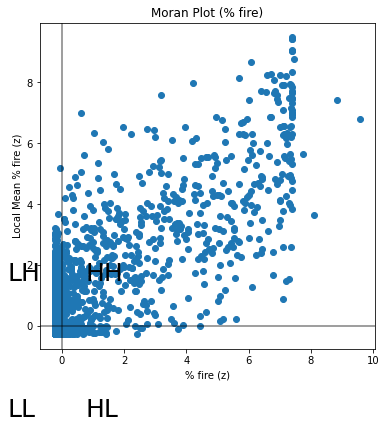

In [162]:
# Setup the figure and axis
fig, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
plt.scatter(dissolve_merged['area_density_z'], dissolve_merged['area_density_lag_z'])
# Add vertical and horizontal lines through zero
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
# Add text labels for each quadrant
plt.text(0.75, 1.5, "HH", fontsize=25)
plt.text(0.75, -3, "HL", fontsize=25)
plt.text(-1.75, 1.5, "LH", fontsize=25)
plt.text(-1.75, -3, "LL", fontsize=25)
# Display
ax.set_title('Moran Plot (% fire)')
ax.set_xlabel("% fire (z)")
ax.set_ylabel("Local Mean % fire (z)")
plt.show()

The four types of point are:

1. HH points are above the overall mean of values *and* above the overall mean of the local means (top right)
2. LH points are below the overall mean of values *but* above the overall mean of the local means (top left)
3. LL points are below the overall mean of values *and* below the overall mean of the local means (bottom left)
4. HL points are above the overall mean of values *but* below the overall mean of the local means (bottom right)

Because each point is a location, we could map in space where the four types are located. 

To do this we first need to create a new Series in our GeoDataFrame indicating which quadrant a location is in: 

In [163]:
def rules(row):
    if row['area_density_z'] > 0:
        if row['area_density_lag_z'] > 0:
            return 'HH'  
        else:
            return 'HL'  
    else:
        if row['area_density_lag_z'] > 0:
            return 'LH'  
        else:
            return 'LL'

dissolve_merged['quadrant'] = dissolve_merged.apply(rules, 1)

The Moran Plot is an excellent tool to explore the data and get a good sense of how much values are clustered over space. However, because it is a graphical device, it is sometimes hard to condense its insights into a more concise way. For these cases, a good approach is to come up with a statistical measure that summarizes the figure. This is exactly what Moran's I, as formally expressed above, is meant to do.

Very much in the same way the mean summarizes a crucial element of the distribution of values in a non-spatial setting, so does Moran's I for a spatial dataset. Continuing the comparison, we can think of the mean as a single numerical value summarizing a histogram or a kernel density plot. Similarly, Moran's I captures much of the essence of the Moran Plot. In fact, there is a close connection between the two: the value of Moran's I corresponds with the slope of the linear fit overlayed on top of the Moran Plot.

## Local Moran's I <a name="local"></a>

Local Moran's $I$ for each location $j$ is given by: 

$$
I_j = \frac{z_i}{m_2} \sum{w_{ij} z_j}
$$

where:

$$
m_2 = \frac{\sum_i{z^2_i}}{n}
$$

For locations with statistically significant Local Moran's $I$ values we can then attribute locations intuitively as follows:

1. HH points are *hot spot* clusters
2. LL points are *cold spot* clusters
3. LH are *doughnut* outliers
4. HL are *diamond* outliers

To calculate Local Moran's $I$ values, we can use the PySAL [`Moran_Local` function](https://pysal.org/esda/generated/esda.Moran_Local.html), passing our variable of interest with our row-standardized spatial weights matrix:

In [122]:
lisa = esda.moran.Moran_Local(dissolve_merged['area_density'], w)

We have just calculated a Moran's $I$ value for every location in the map. These are stored in the `.Is` attribute of the `Moran_Local` object. Let's use that to create a map of the Local $I$s, first creating a new Series in our GeoDataFrame, then plotting it:

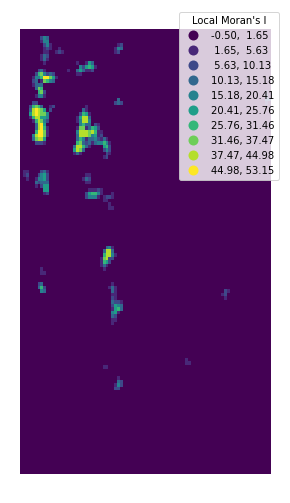

In [133]:
dissolve_merged['Is'] = lisa.Is

fig, ax = plt.subplots(1, figsize=(9, 9))
dissolve_merged.plot(column='Is', cmap='viridis', 
        scheme='naturalbreaks', k=10, 
        legend=True, legend_kwds={"title":"Local Moran's I","loc": 1},
        ax=ax
       )
ax.set_axis_off()

And we can plot the distribution of the Local $I$s:

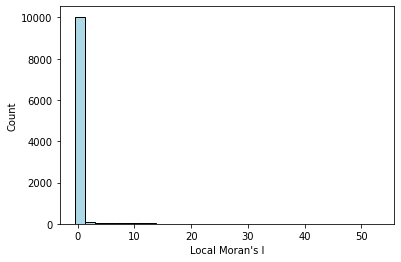

In [136]:
plt.hist(lisa.Is, 30, facecolor='lightblue', edgecolor='black')
plt.xlabel("Local Moran's I")
plt.ylabel("Count")
plt.show()

We see a skewed distribution -- there are no negative values which is due to the dominance of the positive forms of spatial association (i.e. positive global spatial autocorrelation).

The high positive Local  I  values arise from similarity in space of our variable of interest - either high values being next to high values (HH) or low values next to low values (LL). 

The `Moran_Local` uses a permutation (randomisation) approach to produce a pseudo p-value *for each* of our Local $I$ values. We can plot the distribution of these too:

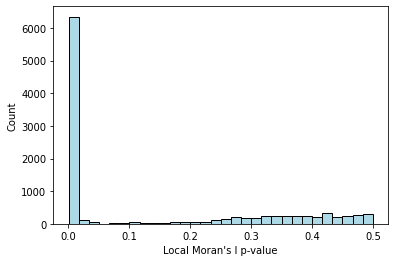

In [137]:
plt.hist(lisa.p_sim, 30, facecolor='lightblue', edgecolor='black')
plt.xlabel("Local Moran's I p-value")
plt.ylabel("Count")
plt.show()

Each p-value here indicates the the probability of incorrectly rejecting the null hypothesis of complete spatial randomness. If we decide on some level of statistical significance, we can identify which locations we believe the Local  I  has not been arrived at by chance.

We'll use 95% confidence here and create a new Series in our GeoDataFrame that indicates if the Local  I  for each location is 'non-significant' or 'significant':

In [138]:
dissolve_merged['p-sim'] = lisa.p_sim

sig = 1 * (lisa.p_sim < 0.05)
slabels = ['non-sig.', 'significant'] 
labels = [slabels[i] for i in sig]

dissolve_merged['sig'] = labels
dissolve_merged[['sig','p-sim']].head(10)

,sig,p-sim
grid_index,,
0,significant,0.00100
1,significant,0.00100
2,significant,0.00100
3,significant,0.00100
4,significant,0.00100
5,significant,0.00100
6,significant,0.00100
7,significant,0.00100
8,significant,0.00100


And now we can map those locations, with darker areas being significant and lighter areas being insignificant:

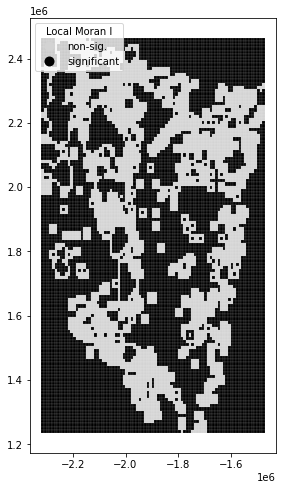

In [142]:
fig, ax = plt.subplots(1,figsize=(10,8))

sigcolors = {'non-sig.':'lightgrey', 'significant':'black'}  

dissolve_merged.plot(column='sig', categorical=True, cmap=colors.ListedColormap(sigcolors.values()),
         k=2, linewidth=0.1, edgecolor='white',
         legend=True, legend_kwds={"title":'Local Moran I',"loc": 2},
         ax=ax)
plt.show()

Now we can combine this map with our map of Local  I s, setting non-significant locations to be a light grey colour (by first creating a new Series):

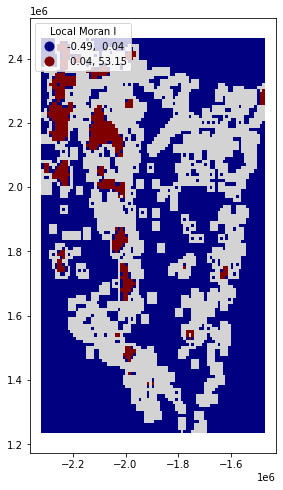

In [150]:
dissolve_merged['sigIs'] = np.where(dissolve_merged['sig'] == 'significant', dissolve_merged['Is'], np.nan)

fig, ax = plt.subplots(1, figsize=(10,8))

dissolve_merged.plot(color='lightgrey',linewidth=0.0,ax=ax)

dissolve_merged.plot(column='sigIs', cmap='jet', scheme='quantiles',
         k=5, edgecolor='white', linewidth=0.0,
         legend=True, legend_kwds={"title":'Local Moran I',"loc": 2},
         ax=ax)
plt.show()

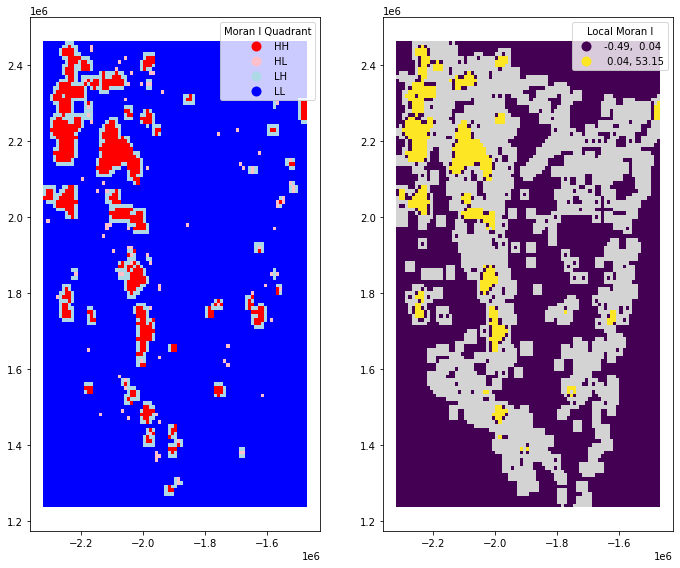

In [165]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

qcolors = {'HH':'red', 'HL':'pink', 'LL':'lightblue', 'LH':'blue'}  

dissolve_merged.plot(column='quadrant', categorical=True, cmap=colors.ListedColormap(qcolors.values()),
         k=2, edgecolor='white', linewidth=0.0,
         legend=True, legend_kwds={"title":'Moran I Quadrant',"loc": 1},
         ax=ax[0])

dissolve_merged.plot(color='lightgrey',linewidth=0.0,ax=ax[1])

dissolve_merged.plot(column='sigIs', cmap='viridis', scheme='quantiles',
         k=5, edgecolor='white', linewidth=0.0,
         legend=True, legend_kwds={"title":'Local Moran I',"loc": 1},
         ax=ax[1])

fig.tight_layout()
plt.show()

#Extra tasks
Have a go at exploring global and local autocorrelation of earthquake-driven landslides, using the dataset you used last week.

**Acknowledgements:** Rey et al 2020 Geographic Data Science (https://geographicdata.science/book/intro.html) & James Millington (https://github.com/jamesdamillington)